# amazon customer review data set

## Here I will create a model to predict the unknown classes(like 'Awesome','good','bad' etc) based on polarity score of the text data and apply it to the new reviews as well as old datafrmae reviews.

## Here I will use Glove+LSTM to create the model

In [1]:
import numpy as np 
import pandas as pd 
import re
import matplotlib.pyplot as plt
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

Using TensorFlow backend.


In [2]:
df=pd.read_csv('../UPDATED_NLP_COURSE/TextFiles/amazonreviews.tsv',sep='\t')
df.head()

,label,review
0,pos,Stuning even for the non-gamer: This sound tra...
1,pos,The best soundtrack ever to anything.: I'm rea...
2,pos,Amazing!: This soundtrack is my favorite music...
3,pos,Excellent Soundtrack: I truly like this soundt...
4,pos,"Remember, Pull Your Jaw Off The Floor After He..."


In [3]:
df['labels']=df['label'].apply(lambda x: 1 if x=='pos' else 0)

In [4]:
df.head()

,label,review,labels
0,pos,Stuning even for the non-gamer: This sound tra...,1
1,pos,The best soundtrack ever to anything.: I'm rea...,1
2,pos,Amazing!: This soundtrack is my favorite music...,1
3,pos,Excellent Soundtrack: I truly like this soundt...,1
4,pos,"Remember, Pull Your Jaw Off The Floor After He...",1


### Text cleaning and preprocessing

In [8]:
def clean_text(text):
    text = text.lower()
    
    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    return text
def CleanTokenize(df):
    head_lines = list()
    lines = df["review"].values.tolist()

    for line in lines:
        line = clean_text(line)
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove non alphabetic characters
        words = [word for word in stripped if word.isalpha()]
        stop_words = set(stopwords.words("english"))
        # remove stop words
        words = [w for w in words if not w in stop_words]
        head_lines.append(words)
    return head_lines

review = CleanTokenize(df)
review[0:10]

[['stuning',
  'even',
  'nongamer',
  'sound',
  'track',
  'beautiful',
  'paints',
  'senery',
  'mind',
  'well',
  'would',
  'recomend',
  'even',
  'people',
  'hate',
  'vid',
  'game',
  'music',
  'played',
  'game',
  'chrono',
  'cross',
  'games',
  'ever',
  'played',
  'best',
  'music',
  'backs',
  'away',
  'crude',
  'keyboarding',
  'takes',
  'fresher',
  'step',
  'grate',
  'guitars',
  'soulful',
  'orchestras',
  'would',
  'impress',
  'anyone',
  'cares',
  'listen'],
 ['best',
  'soundtrack',
  'ever',
  'anything',
  'reading',
  'lot',
  'reviews',
  'saying',
  'best',
  'game',
  'soundtrack',
  'figured',
  'write',
  'review',
  'disagree',
  'bit',
  'opinino',
  'yasunori',
  'mitsuda',
  'ultimate',
  'masterpiece',
  'music',
  'timeless',
  'listening',
  'years',
  'beauty',
  'simply',
  'refuses',
  'fadethe',
  'price',
  'tag',
  'pretty',
  'staggering',
  'must',
  'say',
  'going',
  'buy',
  'cd',
  'much',
  'money',
  'one',
  'feel',
 

In [9]:
y=df.labels.values

### visual representaion of maximum occurance words

(-0.5, 999.5, 499.5, -0.5)

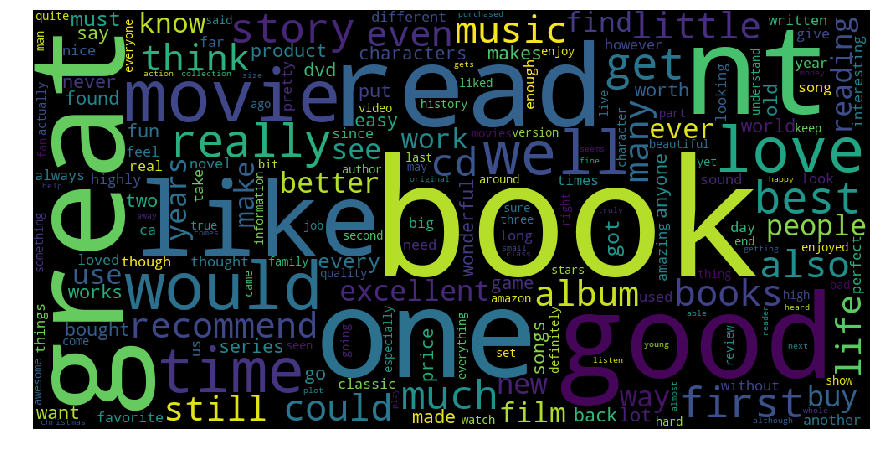

In [12]:
from collections import Counter
from wordcloud import WordCloud, ImageColorGenerator
pos_data = df.loc[df['labels'] == 1]
pos_head_lines = CleanTokenize(pos_data)
pos_lines = [j for sub in pos_head_lines for j in sub] 
word_could_dict=Counter(pos_lines)

wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

### creating tokenizer

In [13]:
tokenizer=Tokenizer()

In [14]:
tokenizer.fit_on_texts(review)
encoded=tokenizer.texts_to_sequences(review)
vocab_size=len(tokenizer.word_index)+1
padded=pad_sequences(encoded,maxlen=25,padding='post')

In [15]:
indices=np.arange(padded.shape[0])
np.random.shuffle(indices)

In [16]:
padded=padded[indices]
y=y[indices]

In [32]:
num_val_sample=int(0.25*padded.shape[0])
num_val_sample

2500

In [33]:
x_train,y_train=padded[:-num_val_sample],y[:-num_val_sample]
x_test,y_test=padded[-num_val_sample:],y[-num_val_sample:]

In [34]:
print('Shape of X_train_pad:', x_train.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', x_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (7500, 25)
Shape of y_train: (7500,)
Shape of X_test_pad: (2500, 25)
Shape of y_test: (2500,)


### importing Glove model from local disk

In [35]:
embedding_index={}
f=open('../DEEP_NLP_resources/data/glove.6B/glove.6B.100d.txt',encoding='utf-8')
for line in f:
    values=line.split()
    word=values[0]
    coef=np.asarray(values[1:],dtype='float32')
    embedding_index[word]=coef
f.close()

### creating embedding layer for cleaned review datasets

In [36]:
embedding_matrix=np.zeros((vocab_size,100))
for word,index in tokenizer.word_index.items():
    embedding_vector=embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[index]=embedding_vector

### creating RNN model

In [52]:
model=Sequential()
model.add(Embedding(input_dim=vocab_size,output_dim=100,input_length=25,weights=[embedding_matrix],trainable=False))
model.add(LSTM(64,dropout=0.2))
#model.add(LSTM(64))
model.add(Dense(40,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 25, 100)           3560300   
_________________________________________________________________
lstm_13 (LSTM)               (None, 64)                42240     
_________________________________________________________________
dense_25 (Dense)             (None, 40)                2600      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 41        
Total params: 3,605,181
Trainable params: 44,881
Non-trainable params: 3,560,300
_________________________________________________________________


In [53]:
history=model.fit(x_train,y_train,epochs=7,batch_size=16,validation_data=(x_test,y_test),verbose=2)

Train on 7500 samples, validate on 2500 samples
Epoch 1/7
 - 20s - loss: 0.5956 - acc: 0.6804 - val_loss: 0.5151 - val_acc: 0.7452
Epoch 2/7
 - 15s - loss: 0.5219 - acc: 0.7425 - val_loss: 0.4962 - val_acc: 0.7548
Epoch 3/7
 - 15s - loss: 0.4800 - acc: 0.7659 - val_loss: 0.4625 - val_acc: 0.7788
Epoch 4/7
 - 15s - loss: 0.4545 - acc: 0.7831 - val_loss: 0.4580 - val_acc: 0.7828
Epoch 5/7
 - 15s - loss: 0.4353 - acc: 0.7965 - val_loss: 0.4748 - val_acc: 0.7784
Epoch 6/7
 - 15s - loss: 0.4092 - acc: 0.8129 - val_loss: 0.4447 - val_acc: 0.7896
Epoch 7/7
 - 15s - loss: 0.3799 - acc: 0.8268 - val_loss: 0.4769 - val_acc: 0.7944


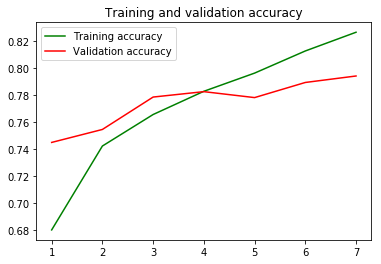

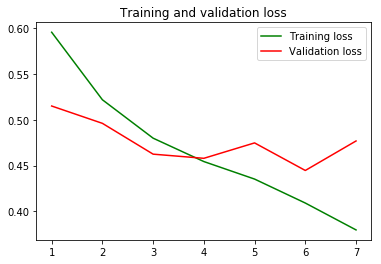

In [54]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### tried multiple times to increase the acc level for both training and validation. Using different hyper tuning, I found this model is giving a better result.

### creating function for predict the sentiment

In [95]:
def predict_sentiment(doc):
# clean review
    lines=pd.DataFrame({'review':[doc]})
    line = CleanTokenize(lines)
    sequence=tokenizer.texts_to_sequences(line)
    padding=pad_sequences(sequence,maxlen=25,padding='post')
# predict sentiment
    pred = model.predict(padding, verbose=0)
    pred*=100
    if pred[0][0]>=80: return "Awesome" 
    elif pred[0][0]>=60: return "Good"
    elif pred[0][0]>=40: return 'Average'
    else: return 'Bad'

### testing on new reviews

In [83]:
text='Excellent movie. I suggest everyone to see the movie and enjoy'
text1='Too Bad cinema. Actor was good but story line was worst. Do not waste time'

In [84]:
predict_sentiment(text)

'Awesome'

In [85]:
predict_sentiment(text1)

'Bad'

In [86]:
df.review[8]

"A FIVE STAR BOOK: I just finished reading Whisper of the Wicked saints. I fell in love with the caracters. I expected an average romance read, but instead I found one of my favorite books of all time. Just when I thought I could predict the outcome I was shocked ! The writting was so descriptive that my heart broke when Julia's did and I felt as if I was there with them instead of just a distant reader. If you are a lover of romance novels then this is a must read. Don't let the cover fool you this book is spectacular!"

In [87]:
c=df.review[8]

In [96]:
predict_sentiment(c)

'Good'

In [89]:
df.review[500]

'Economics even you will Understand: For all who avoided economics like the plague, this is the book for you.very informative, and gives the novice a good foundation of the subject... Check it out.. next time you argue economics with uncle Fred, you wont sound like such a dope'

In [90]:
d=df.review[500]

In [91]:
predict_sentiment(d)

'Good.'

In [92]:
e=df.review[80]

In [94]:
df.review[80]

'audio options non existent: While the movie in itself was better than i expected what i didnt expect was the "non existent" Thai soundtrack. While the option was on the disc menu (as well as stated on the package) the Thai soundtrack does not exist. No matter what you choose, Thai or English, English is what you get and while there are some exceptions most dubbing is ridiculous at best and the dubbing on this title is sub par. While this review covers only the first movie of the two the other may remain in plastic never to see the inside of my dvd player. Its a shame and a sham when you purchase what claims to be original and is not. Very disapointed in this offering from Tokyo Shock.'

In [93]:
predict_sentiment(e)

'Bad'

### implimenting the sentiment level on old dataset 

In [97]:
df['satisfaction']=df['review'].apply(lambda x: predict_sentiment(x))

In [100]:
df.drop(['label','labels'],axis=1,inplace=True)

In [101]:
df.head(20)

,review,satisfaction
0,Stuning even for the non-gamer: This sound tra...,Awesome
1,The best soundtrack ever to anything.: I'm rea...,Average
2,Amazing!: This soundtrack is my favorite music...,Good
3,Excellent Soundtrack: I truly like this soundt...,Awesome
4,"Remember, Pull Your Jaw Off The Floor After He...",Good
5,an absolute masterpiece: I am quite sure any o...,Awesome
6,"Buyer beware: This is a self-published book, a...",Bad
7,Glorious story: I loved Whisper of the wicked ...,Awesome
8,A FIVE STAR BOOK: I just finished reading Whis...,Good
9,Whispers of the Wicked Saints: This was a easy...,Good
